In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': 'category',
         'SchoolHoliday': 'category'
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': 'category',
         'Assortment': 'category',
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': 'category',
         'Promo2SinceYear': 'category',
         'PromoInterval': 'category'
        }

train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
store = pd.read_csv('input/store.csv', dtype=store_data_types)

In [4]:
print('- Train data')
print(train.dtypes)

- Train data
Store                     int32
DayOfWeek              category
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                   category
Promo                  category
StateHoliday           category
SchoolHoliday          category
dtype: object


In [5]:
print('- Test data')
print(test.dtypes)

- Test data
Id                        int32
Store                     int32
DayOfWeek              category
Date             datetime64[ns]
Open                   category
Promo                  category
StateHoliday           category
SchoolHoliday          category
dtype: object


In [6]:
print('- Store data')
print(store.dtypes)

- Store data
Store                           int32
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth      object
CompetitionOpenSinceYear       object
Promo2                       category
Promo2SinceWeek              category
Promo2SinceYear              category
PromoInterval                category
dtype: object


# Data exploration

In [7]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1017209.000000,1017209,1017209,1017209.000000,1017209.000000,1017209,1017209,1017209,1017209
unique,nan,7,942,nan,nan,2,2,4,2
top,nan,5,2015-06-09 00:00:00,nan,nan,1,0,0,0
freq,nan,145845,1115,nan,nan,844392,629129,986159,835488
first,nan,NaN,2013-01-01 00:00:00,nan,nan,NaN,NaN,NaN,NaN
last,nan,NaN,2015-07-31 00:00:00,nan,nan,NaN,NaN,NaN,NaN
mean,558.429727,NaN,NaN,5773.818972,633.145946,NaN,NaN,NaN,NaN
std,321.908651,NaN,NaN,3849.926175,464.411734,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,280.000000,NaN,NaN,3727.000000,405.000000,NaN,NaN,NaN,NaN


In [8]:
test.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088,41088,41077,41088,41088,41088
unique,nan,nan,7,48,2,2,2,2
top,nan,nan,7,2015-09-15 00:00:00,1,0,0,0
freq,nan,nan,5992,856,35093,24824,40908,22866
first,nan,nan,NaN,2015-08-01 00:00:00,NaN,NaN,NaN,NaN
last,nan,nan,NaN,2015-09-17 00:00:00,NaN,NaN,NaN,NaN
mean,20544.500000,555.899533,NaN,NaN,NaN,NaN,NaN,NaN
std,11861.228267,320.274496,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,10272.750000,279.750000,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.000000,1115,1115,1112.000000,761,761,1115,571,571,571
unique,nan,4,3,nan,12,23,2,24,7,3
top,nan,a,a,nan,9,2013,1,14,2011,"Jan,Apr,Jul,Oct"
freq,nan,602,593,nan,125,83,571,81,128,335
mean,558.000000,NaN,NaN,5404.901079,NaN,NaN,NaN,NaN,NaN,NaN
std,322.017080,NaN,NaN,7663.174720,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,279.500000,NaN,NaN,717.500000,NaN,NaN,NaN,NaN,NaN,NaN
50%,558.000000,NaN,NaN,2325.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,836.500000,NaN,NaN,6882.500000,NaN,NaN,NaN,NaN,NaN,NaN


## Find unique value

In [10]:
print('- Unique train data without null value')
print(train.nunique())
print('*'*30)
print('- Unique train data with null value')
print(train.nunique(dropna=False))

- Unique train data without null value
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64
******************************
- Unique train data with null value
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64


In [11]:
# open value has 3 values so we will check it again. (Include null value)
print('- Unique test data without null value')
print(test.nunique())
print('*'*30)
print('- Unique test data with null value')
print(test.nunique(dropna=False))

- Unique test data without null value
Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64
******************************
- Unique test data with null value
Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 3
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64


In [12]:
# CompetitionDistance, OpenSinceMonth, OpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval
# contain null value in store data
print('- Unique store data without null value')
print(store.nunique())
print('*'*30)
print('- Unique store data with null value')
print(store.nunique(dropna=False))

- Unique store data without null value
Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64
******************************
- Unique store data with null value
Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           655
CompetitionOpenSinceMonth      13
CompetitionOpenSinceYear       24
Promo2                          2
Promo2SinceWeek                25
Promo2SinceYear                 8
PromoInterval                   4
dtype: int64


In [13]:
# All test stores are in the train data
np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

856

In [14]:
# 259 stores in train data are not in test data
train.Store.nunique() - np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

259

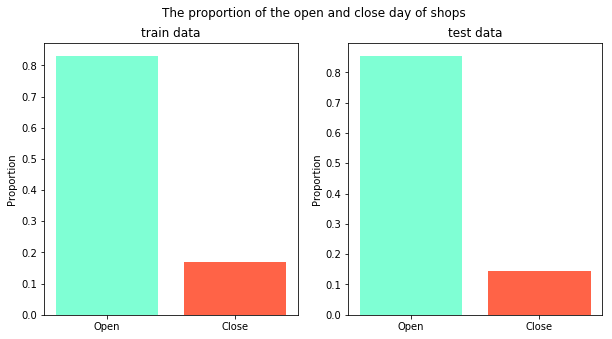

In [16]:
# The proportion of open and close in train data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x_train = [len(train.Open[train['Open'] == '1'])/len(train.Open), len(train.Open[train['Open'] == '0'])/len(train.Open)]
x_test = [len(test.Open[test['Open'] == '1'])/len(test.Open), len(test.Open[test['Open'] == '0'])/len(test.Open)]

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=['aquamarine','tomato'])
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects))
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=['aquamarine','tomato'])
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects))
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the open and close day of shops')
plt.show()

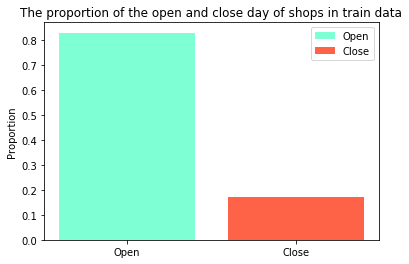

In [17]:
# no longer use
# The proportion of open and close in train data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x = [len(train.Open[train['Open'] == '1'])/len(train.Open), len(train.Open[train['Open'] == '0'])/len(train.Open)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['aquamarine','tomato'])
plt.xticks(y, objects)
plt.ylabel('Proportion'),
plt.title('The proportion of the open and close day of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [18]:
# on test data, the open column contains null value
test.Open[test["Open"].isnull()]

479      NaN
1335     NaN
2191     NaN
3047     NaN
4759     NaN
5615     NaN
6471     NaN
7327     NaN
8183     NaN
9039     NaN
10751    NaN
Name: Open, dtype: category
Categories (2, object): [0, 1]

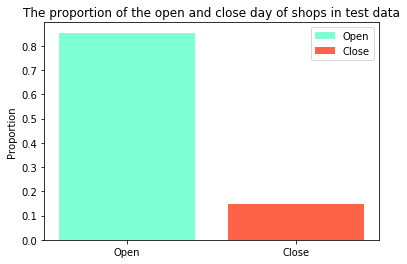

In [19]:
# no longer use
# The proportion of open and close in test data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x = [len(test.Open[test['Open'] == '1'])/len(test.Open), len(test.Open[test['Open'] == '0'])/len(test.Open)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['aquamarine', 'tomato'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the open and close day of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

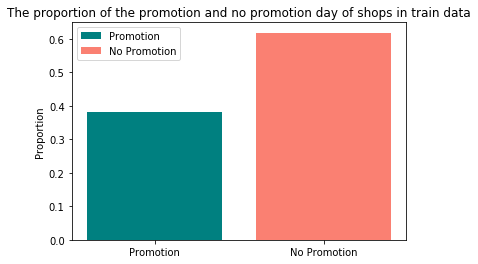

In [20]:
# The proportion of promotion and no promotion day in train data 
objects = ('Promotion', 'No Promotion')
y = np.arange(len(objects))
x = [len(train.Promo[train['Promo'] == '1'])/len(train.Promo), len(train.Promo[train['Promo'] == '0'])/len(train.Promo)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['teal','salmon'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the promotion and no promotion day of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

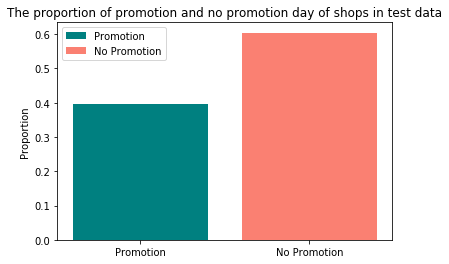

In [21]:
# The proportion of promotion and no promotion day in test data 
objects = ('Promotion', 'No Promotion')
y = np.arange(len(objects))
x = [len(test.Promo[test["Promo"] == '1'])/len(test.Promo), len(test.Promo[test["Promo"] == '0'])/len(test.Promo)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['teal','salmon'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of promotion and no promotion day of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

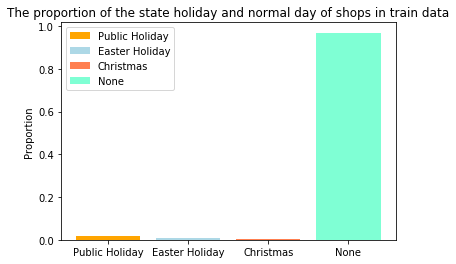

In [22]:
# The proportion of holiday and normal day in train data 
objects = ('Public Holiday', 'Easter Holiday', 'Christmas', 'None')
y = np.arange(len(objects))
x = [len(train.StateHoliday[train["StateHoliday"] == 'a'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == 'b'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == 'c'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == '0'])/len(train.StateHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['orange', 'lightblue', 'coral', 'aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the state holiday and normal day of shops in train data')
plt.legend([ax[0], ax[1], ax[2], ax[3]], list(objects))
plt.show()

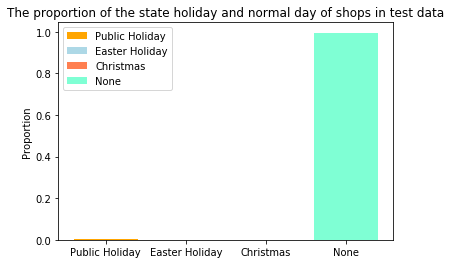

In [25]:
# The proportion of holiday and normal day in test data 
objects = ('Public Holiday', 'Easter Holiday', 'Christmas', 'None')
y = np.arange(len(objects))
x = [len(test.StateHoliday[test["StateHoliday"] == 'a'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == 'b'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == 'c'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == '0'])/len(test.StateHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['orange', 'lightblue', 'coral', 'aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the state holiday and normal day of shops in test data')
plt.legend([ax[0], ax[1], ax[2], ax[3]], list(objects))
plt.show()

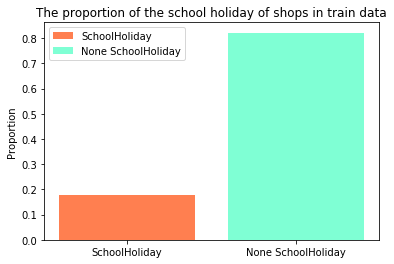

In [26]:
objects = ('SchoolHoliday', 'None SchoolHoliday')
y = np.arange(len(objects))
x = [len(train.SchoolHoliday[train["SchoolHoliday"] == '1'])/len(train.SchoolHoliday), 
               len(train.SchoolHoliday[train["SchoolHoliday"] == '0'])/len(train.SchoolHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['coral','aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the school holiday of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

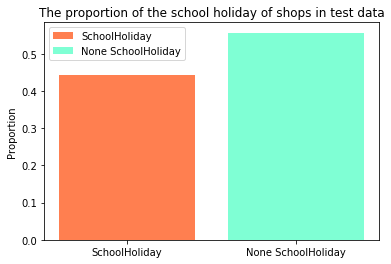

In [27]:
objects = ('SchoolHoliday', 'None SchoolHoliday')
y = np.arange(len(objects))
x = [len(test.SchoolHoliday[test["SchoolHoliday"] == '1'])/len(test.SchoolHoliday),
               len(test.SchoolHoliday[test["SchoolHoliday"] == '0'])/len(test.SchoolHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['coral','aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the school holiday of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

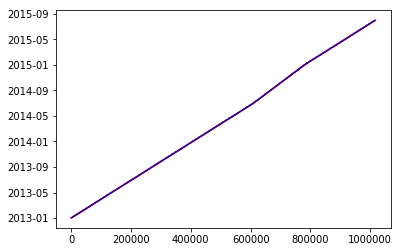

In [28]:
plt.plot(train.Date.sort_values(ascending=True).reset_index(drop=True), color="indigo")
plt.show()

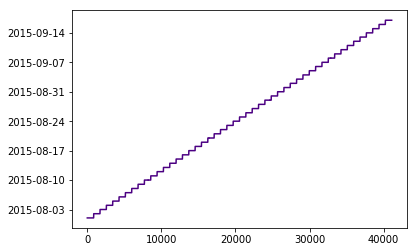

In [29]:
# we have to predict 48 days in test data
plt.plot(test.Date.sort_values(ascending=True).reset_index(drop=True), color="indigo")
plt.show()

(array([1.72877e+05, 1.07000e+02, 6.20000e+02, 1.89600e+03, 4.13000e+03,
        8.39000e+03, 1.41860e+04, 2.16560e+04, 3.14910e+04, 4.13200e+04,
        4.93110e+04, 5.53090e+04, 5.84920e+04, 5.91820e+04, 5.79320e+04,
        5.40820e+04, 4.93650e+04, 4.49760e+04, 4.12180e+04, 3.56050e+04,
        3.09410e+04, 2.65370e+04, 2.31100e+04, 1.95920e+04, 1.69870e+04,
        1.44620e+04, 1.21680e+04, 1.02250e+04, 8.60900e+03, 7.16100e+03,
        6.04700e+03, 5.08100e+03, 4.37100e+03, 3.73900e+03, 3.23900e+03,
        2.79300e+03, 2.41100e+03, 2.03900e+03, 1.84100e+03, 1.67300e+03,
        1.45600e+03, 1.20800e+03, 1.10900e+03, 1.03500e+03, 9.09000e+02,
        7.95000e+02, 7.42000e+02, 6.14000e+02, 5.48000e+02, 4.85000e+02,
        4.15000e+02, 3.52000e+02, 3.38000e+02, 2.56000e+02, 2.61000e+02,
        2.03000e+02, 1.83000e+02, 1.39000e+02, 9.90000e+01, 1.16000e+02,
        9.20000e+01, 6.70000e+01, 7.10000e+01, 6.10000e+01, 7.30000e+01,
        4.50000e+01, 4.00000e+01, 5.00000e+01, 3.30

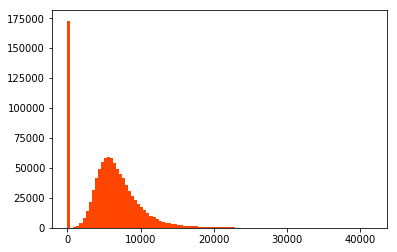

In [30]:
# histogram of sales in train data
# According to histogram, there are too many zero sales on train data
plt.hist(train.Sales, 100, color="orangered")

(array([ 2.,  5.,  5.,  6., 14., 11., 18., 16., 21., 37., 29., 42., 37.,
        51., 47., 31., 48., 43., 42., 38., 40., 33., 58., 43., 38., 33.,
        36., 28., 17., 26., 20., 20., 13., 15., 18., 17., 10., 12.,  3.,
        11.,  4.,  8., 10.,  7.,  6.,  1.,  5.,  3.,  2.,  3.,  0.,  0.,
         3.,  2.,  3.,  1.,  1.,  2.,  2.,  1.,  0.,  1.,  0.,  1.,  2.,
         1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2703.73657289,  2894.27404134,  3084.8115098 ,  3275.34897825,
         3465.88644671,  3656.42391516,  3846.96138362,  4037.49885207,
         4228.03632053,  4418.57378898,  4609.11125744,  4799.64872589,
         4990.18619435,  5180.7236628 ,  5371.26113126,  5561.79859971,
         5752.33606817,  5942.87353662,  6133.41100508,  6323.94847353,
         6514.48594199,  6705.02341044,  6895.5608789 ,  7086.09834735,
  

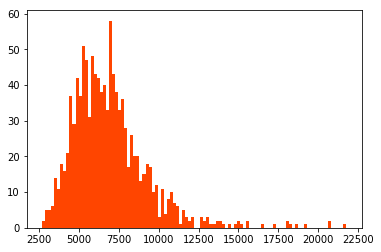

In [31]:
# Show the histogram of mean sales seperated by storeID.
# We have to filter out rows that contain zero sales 
plt.hist(train[train["Sales"] != 0].groupby(['Store']).Sales.mean(),100, color="orangered")

(array([1.72884e+05, 7.30000e+02, 3.77200e+03, 1.47080e+04, 3.54060e+04,
        6.47450e+04, 9.01850e+04, 1.01267e+05, 9.74110e+04, 8.76340e+04,
        7.34540e+04, 5.92830e+04, 4.71420e+04, 3.68090e+04, 2.76340e+04,
        2.12360e+04, 1.55560e+04, 1.20940e+04, 9.26800e+03, 7.24400e+03,
        5.65300e+03, 4.60100e+03, 3.72400e+03, 3.17400e+03, 2.60200e+03,
        2.25900e+03, 1.86300e+03, 1.53900e+03, 1.33000e+03, 1.10100e+03,
        1.01200e+03, 9.10000e+02, 7.83000e+02, 7.00000e+02, 6.44000e+02,
        5.77000e+02, 4.77000e+02, 4.34000e+02, 4.50000e+02, 4.43000e+02,
        4.52000e+02, 4.26000e+02, 5.04000e+02, 4.62000e+02, 4.23000e+02,
        4.02000e+02, 3.74000e+02, 2.79000e+02, 2.44000e+02, 1.80000e+02,
        1.66000e+02, 9.10000e+01, 7.70000e+01, 6.50000e+01, 5.20000e+01,
        5.10000e+01, 3.20000e+01, 2.80000e+01, 3.20000e+01, 1.90000e+01,
        2.50000e+01, 2.00000e+01, 1.80000e+01, 6.00000e+00, 8.00000e+00,
        6.00000e+00, 7.00000e+00, 5.00000e+00, 6.00

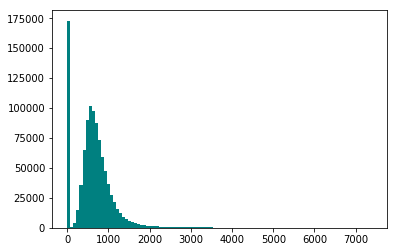

In [32]:
# histogram of customers in train data
# According to histogram, there are zero customers on train data
plt.hist(train.Customers,100, color="teal")

(array([ 2.,  0.,  9., 16., 23., 30., 46., 51., 69., 69., 68., 58., 67.,
        62., 72., 50., 46., 35., 38., 37., 29., 21., 32., 20., 23., 11.,
        14., 13., 14.,  6.,  5.,  6.,  7.,  8.,  4.,  3.,  6.,  1.,  2.,
         1.,  3.,  2.,  4.,  3.,  3.,  1.,  2.,  0.,  4.,  0.,  1.,  0.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 240.18309859,  271.81585359,  303.44860859,  335.0813636 ,
         366.7141186 ,  398.3468736 ,  429.9796286 ,  461.6123836 ,
         493.2451386 ,  524.8778936 ,  556.51064861,  588.14340361,
         619.77615861,  651.40891361,  683.04166861,  714.67442361,
         746.30717861,  777.93993361,  809.57268862,  841.20544362,
         872.83819862,  904.47095362,  936.10370862,  967.73646362,
         999.36921862, 103

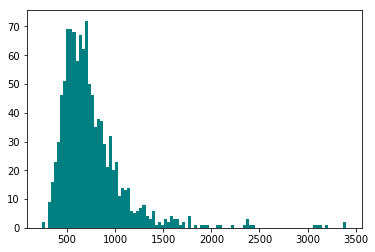

In [33]:
# Show the histogram of mean customers seperated by storeID.
# We have to filter out rows that contain zero sales 
plt.hist(train[train["Sales"] != 0].groupby(['Store']).Customers.mean(),100, color="teal")

## Sales and other features

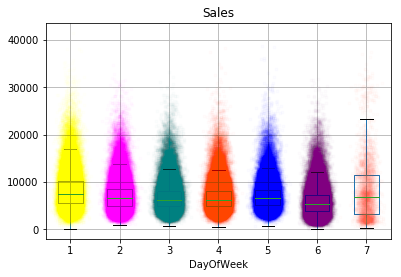

In [34]:
# Add boxplot to see a relation between sales and day of week
# May be shops might close on Sunday. 
# So, the density of sales on Sundey is not thick.
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1,8): # 1-7
    y = train[train["Sales"] != 0].Sales[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])


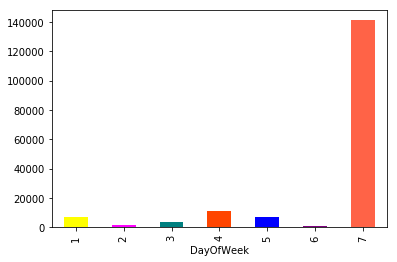

In [35]:
# Count the total number of closed shop by day of week.
# It related to density of the above graph.
train[train["Open"] == '0'].groupby('DayOfWeek').DayOfWeek.count().plot.bar(
    color=['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato'])

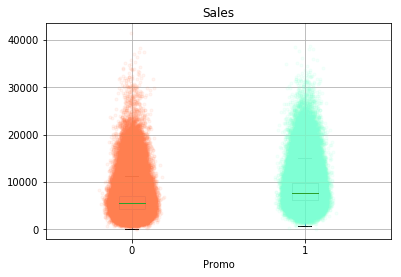

In [36]:
# Add boxplot to see a relation between sales and promotion
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.07, color= colors[i])


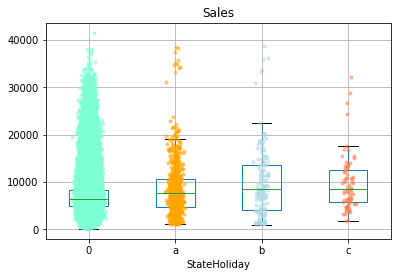

In [37]:
# Add boxplot to see a relation between sales and state holiday
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Sales"] != 0].Sales[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

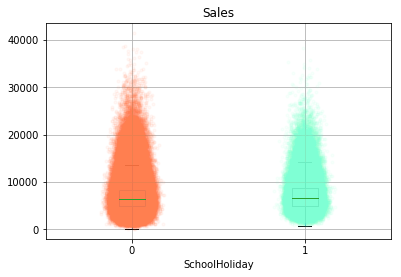

In [38]:
# Add boxplot to see a relation between sales and school holiday
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05, color= colors[i])

## Customers and other features

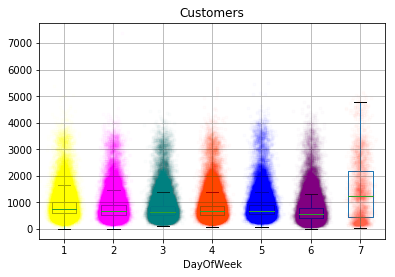

In [41]:
# Add boxplot to see a relation between customers and day of week
# May be shops might close on Sunday. 
# So, the density of customers on Sundey is not thick as same as on sales
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1,8): # 1-7
    y = train[train["Customers"] != 0].Customers[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])


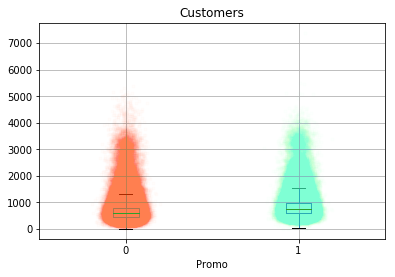

In [42]:
# Add boxplot to see a relation between customers and promotion
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color= colors[i])


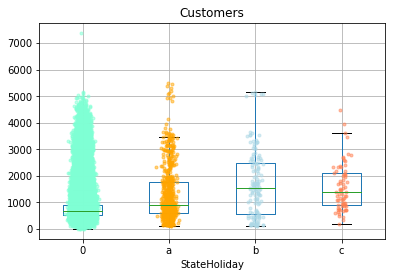

In [43]:
# Add boxplot to see a relation between customers and state holiday
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Customers"] != 0].Customers[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

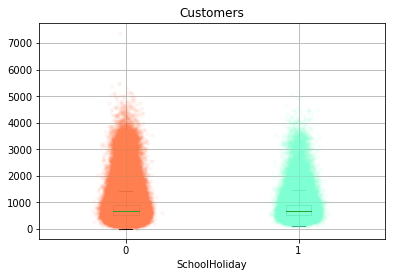

In [44]:
# Add boxplot to see a relation between customers and school holiday
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, '.', alpha=0.05, color= colors[i])

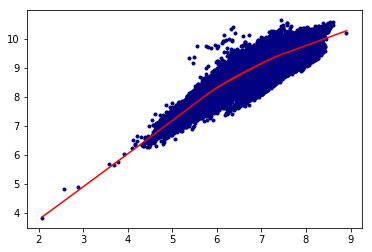

In [49]:
# Sales and Customers with regression line
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sale_and_customer = train[["Sales","Customers"]][(train["Sales"] != 0) & (train["Customers"] != 0)]

x = np.log(sale_and_customer.Customers)
y = np.log(sale_and_customer.Sales)

plt.plot(x, y, '.', color='navy')

filtered = lowess(y, x, is_sorted=False, frac=0.2, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')



In [50]:
# There are just 2 rows that have customers but do not have sales.
train[["Sales","Customers"]][(train["Sales"] == 0) & (train["Customers"] != 0)]

,Sales,Customers
478649,0,3
889932,0,5


(array([  4.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   1.,   0.,   2.,   1.,   5.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 161.,   9.,   1.,
          1.,   1.,   2.,   2.,   3., 259., 476.,  96.,   7.,  11.,  20.,
         14.,   3.,   2.,   5.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 10.  ,  13.01,  16.02,  19.03,  22.04,  25.05,  28.06,  31.07,
         34.08,  37.09,  40.1 ,  43.11,  46.12,  49.13,  52.14,  55.15,
         58.16,  61.17,  64.18,  67.19,  70.2 ,  73.21,  76.22,  79.23,
         82.24,  85.25,  88.26,  91.27,  94.28,  97.29, 100.3 , 103.31,
        106.32, 109.33, 112.34

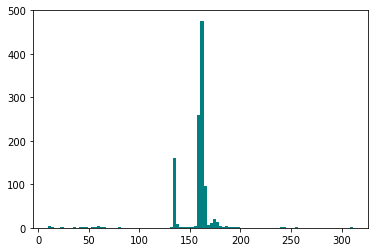

In [51]:
# Stores that have zero sales in each day
# The stores have different amounts of zero sales
# So, we will explore in the next step
storeWithZeroSales = train[(train["Sales"] == 0)].groupby(['Store']).Sales.size().sort_values(ascending=False)
plt.hist(storeWithZeroSales,100, color="teal")

In [52]:
# Store 103 have the most zero sales among all stores
storeWithZeroSales.head()

Store
103    311
708    255
349    242
972    240
674    197
Name: Sales, dtype: int64

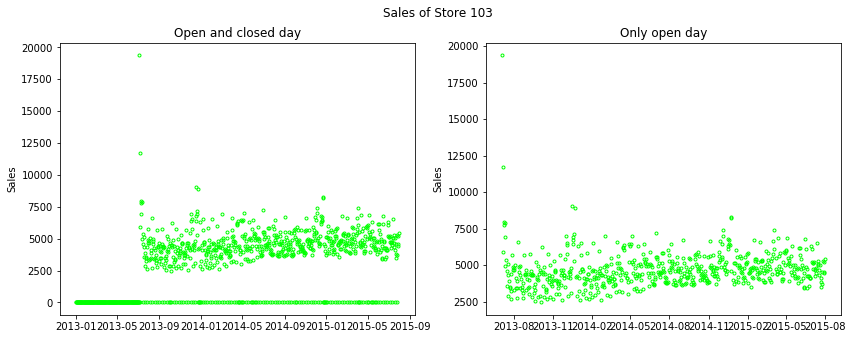

In [53]:
# The sales of store 103 
# The first period that new store openning have a high spike on sales
salesByDayStore103 = train[["Sales","Date"]][train["Store"] == 103]
salesByDayStore103WithOpen = train[["Sales","Date"]][(train["Store"] == 103) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore103.Date, salesByDayStore103.Sales,'o',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore103WithOpen.Date, salesByDayStore103WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 103')
plt.show()

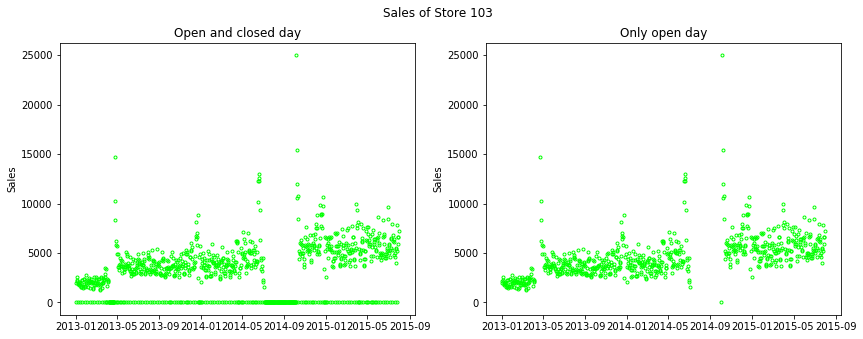

In [54]:
# The sales of store 708 
# When stores open after closing for a while, there is a high spike on sales
# It is the same case as closing. When the stores will close for a while, the last day will have a high spike on sales.
salesByDayStore708 = train[["Sales","Date"]][train["Store"] == 708]
salesByDayStore708WithOpen = train[["Sales","Date"]][(train["Store"] == 708) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore708.Date, salesByDayStore708.Sales,'ro',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore708WithOpen.Date, salesByDayStore708WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 103')
plt.show()

In [55]:
# There are some shops that open twentyfour-seven

train[(train["Open"] == '1') & (train["DayOfWeek"] == '7') & (train["StateHoliday"] != '0')].groupby(["Store"]).Store.head()

1010872    353
1011467    948
Name: Store, dtype: int32

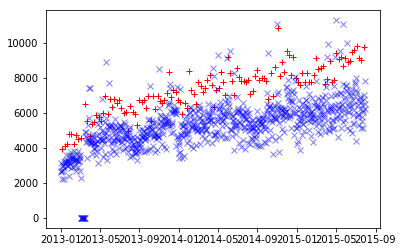

In [56]:
# The sales of store 353 
# The sales on Sunday is higher than other days.
salesByDayOnSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] == '7')]


plt.plot(salesByDayOnSundayStore353.Date, salesByDayOnSundayStore353.Sales, 'r+', alpha=1)



#Highest sale on sunday and doesnot have 0 sales
salesByDayNotSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] != '7')]

plt.plot(salesByDayNotSundayStore353.Date, salesByDayNotSundayStore353.Sales, 'bx', alpha=0.5)


# Store Data

In [ ]:
store.describe(include='all')

In [ ]:
store.StoreType.value_counts()

In [ ]:
store.Assortment.value_counts()

In [ ]:
store.PromoInterval.value_counts()

In [ ]:
pd.crosstab(store.StoreType,store.Assortment)

In [ ]:
len(store.CompetitionDistance.dropna())

In [ ]:
plt.hist(store.CompetitionDistance.dropna(), 100)

In [ ]:
monthNullAndYearNotNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(store["CompetitionOpenSinceMonth"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
monthNotNullAndYearNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(~store["CompetitionOpenSinceMonth"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]

print('monthNullAndYearNotNull', len(monthNullAndYearNotNull))
print('monthNotNullAndYearNull', len(monthNotNullAndYearNull))

In [ ]:
distanceNullAndYearNotNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(store["CompetitionDistance"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
distanceNotNullAndYearNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(~store["CompetitionDistance"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]
print('distanceNullAndYearNotNull', len(distanceNullAndYearNotNull))
print('distanceNotNullAndYearNull', len(distanceNotNullAndYearNull))


In [ ]:
# some of row have distance but doesn't have year and month
# we have to fix it later.
distanceNotNullAndYearNull.head()

In [ ]:
competitionOpenYearMonth = store.CompetitionOpenSinceYear.str.cat(store.CompetitionOpenSinceMonth)
competitionOpenYearMonth = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore').dt.to_period('M')

In [ ]:
competitionOpenYearMonth.head()

In [ ]:
newestCompetitionYearMonth = competitionOpenYearMonth.sort_values(ascending = False).iloc[0]

In [ ]:
openSinceInMonth = newestCompetitionYearMonth - competitionOpenYearMonth

In [ ]:
openSinceInMonth = openSinceInMonth.astype('int32')
plt.hist(openSinceInMonth,100)

In [ ]:
promoWeekNullAndYearNotNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(store["Promo2SinceWeek"].isnull()) & (~store["Promo2SinceYear"].isnull())]
promoWeekNotNullAndYearNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(~store["Promo2SinceWeek"].isnull()) & (store["Promo2SinceYear"].isnull())]

print('promoWeekNullAndYearNotNull', len(promoWeekNullAndYearNotNull))
print('promoWeekNotNullAndYearNull', len(promoWeekNotNullAndYearNull))

In [ ]:
promoUseAndYearNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == 1) & (store["Promo2SinceYear"].isnull())]
promoNotUseAndYearNotNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == 0) & (~store["Promo2SinceYear"].isnull())]
print('promoUseAndYearNull', len(promoUseAndYearNull))
print('promoNotUseAndYearNotNull', len(promoNotUseAndYearNotNull))


In [ ]:
promoUseAndIntervalNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == 1) & (store["PromoInterval"].isnull())]
promoNotUseAndIntervalNotNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == 0) & (~store["PromoInterval"].isnull())]
print('promoUseAndIntervalNull', len(promoUseAndIntervalNull))
print('promoNotUseAndIntervalNotNull', len(promoNotUseAndIntervalNotNull))


In [ ]:
promoStartYearMonth = store[(store["Promo2"] == 1)][['Promo2SinceYear','Promo2SinceWeek']]
#Weekday will start on monday.
promoStartYearMonth = pd.to_datetime(promoStartYearMonth.Promo2SinceWeek.astype(str)+
                          promoStartYearMonth.Promo2SinceYear.astype(str).add('-1') ,format='%W%Y-%w')
    


In [ ]:
promoStartYearMonth.head()

In [ ]:
type(promoStartYearMonth)

In [ ]:
newestPromoStartYearMonth = pd.to_datetime(promoStartYearMonth.sort_values(ascending = False).iloc[0])

In [ ]:
newestPromoStartYearMonth - promoStartYearMonth

In [ ]:
promoSinceInMonth = newestPromoStartYearMonth - promoStartYearMonth
promoSinceInMonth = promoSinceInMonth.astype('timedelta64[D]')
plt.hist(promoSinceInMonth,100)

In [ ]:
store.PromoInterval.value_counts()

In [ ]:
saleAndStore = pd.merge(pre_train, store, on='Store')
saleAndStore = saleAndStore.fillna({'PromoInterval': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
#for i in [0, 1]:




y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Feb,May,Aug,Nov']
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Jan,Apr,Jul,Oct']
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Mar,Jun,Sept,Dec']
# Add some random "jitter" to the x-axis
x = np.random.normal(3, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval== 'None']
# Add some random "jitter" to the x-axis
x = np.random.normal(4, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

saleDateByStore = saleAndStore[(saleAndStore["Sales"] != 0)][["StoreType","Date","Sales"]]
saleDateByStore = saleDateByStore.groupby(['StoreType','Date']).Sales.mean().reset_index()
saleDateByStoreA = saleDateByStore[saleDateByStore["StoreType"] == 'a'][['Date','Sales']]
saleDateByStoreB = saleDateByStore[saleDateByStore["StoreType"] == 'b'][['Date','Sales']]
saleDateByStoreC = saleDateByStore[saleDateByStore["StoreType"] == 'c'][['Date','Sales']]
saleDateByStoreD = saleDateByStore[saleDateByStore["StoreType"] == 'd'][['Date','Sales']]

filteredA = lowess(saleDateByStoreA.Sales, saleDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByStoreB.Sales, saleDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByStoreC.Sales, saleDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(saleDateByStoreD.Sales, saleDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y')

#x_smooth = np.linspace(saleDateByStore.Date.min().value, saleDateByStore.Date.max().value, 100)
#yhat = savitzky_golay(saleDateByStore.Sales, 51, 3)
#plt.plot(x_smooth, yhat,'-b')

In [ ]:
customerDateByStore = saleAndStore[(saleAndStore["Customers"] != 0)][["StoreType","Date","Customers"]]
customerDateByStore = customerDateByStore.groupby(['StoreType','Date']).Customers.mean().reset_index()
customerDateByStoreA = customerDateByStore[customerDateByStore["StoreType"] == 'a'][['Date','Customers']]
customerDateByStoreB = customerDateByStore[customerDateByStore["StoreType"] == 'b'][['Date','Customers']]
customerDateByStoreC = customerDateByStore[customerDateByStore["StoreType"] == 'c'][['Date','Customers']]
customerDateByStoreD = customerDateByStore[customerDateByStore["StoreType"] == 'd'][['Date','Customers']]

filteredA = lowess(customerDateByStoreA.Customers, customerDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(customerDateByStoreB.Customers, customerDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(customerDateByStoreC.Customers, customerDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(customerDateByStoreD.Customers, customerDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y')

In [ ]:
saleDateByAssortment = saleAndStore[(saleAndStore["Sales"] != 0)][["Assortment","Date","Sales"]]
saleDateByAssortment = saleDateByAssortment.groupby(['Assortment','Date']).Sales.mean().reset_index()
saleDateByAssortmentA = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'a'][['Date','Sales']]
saleDateByAssortmentB = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'b'][['Date','Sales']]
saleDateByAssortmentC = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'c'][['Date','Sales']]

filteredA = lowess(saleDateByAssortmentA.Sales, saleDateByAssortmentA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByAssortmentB.Sales, saleDateByAssortmentB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByAssortmentC.Sales, saleDateByAssortmentC.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')

In [ ]:
customerDateByAssortment = saleAndStore[(saleAndStore["Customers"] != 0)][["Assortment","Date","Customers"]]
customerDateByAssortment = customerDateByAssortment.groupby(['Assortment','Date']).Customers.mean().reset_index()
customerDateByAssortmentA = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'a'][['Date','Customers']]
customerDateByAssortmentB = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'b'][['Date','Customers']]
customerDateByAssortmentC = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'c'][['Date','Customers']]

filteredA = lowess(customerDateByAssortmentA.Customers, customerDateByAssortmentA.Date, is_sorted=False, frac=0.3, it=0)
filteredB = lowess(customerDateByAssortmentB.Customers, customerDateByAssortmentB.Date, is_sorted=False, frac=0.3, it=0)
filteredC = lowess(customerDateByAssortmentC.Customers, customerDateByAssortmentC.Date, is_sorted=False, frac=0.3, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')

In [ ]:
sale_and_distance = saleAndStore[["Sales","CompetitionDistance"]][(saleAndStore["Sales"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Sales.mean().reset_index()

x = np.log(sale_and_distance.CompetitionDistance)
y = np.log(sale_and_distance.Sales)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

In [ ]:
SalesAndCompetition = saleAndStore[['Sales','CompetitionOpenSinceYear']]

SalesAndCompetition['isCompetition'] = np.where(~SalesAndCompetition['CompetitionOpenSinceYear'].isnull(), 1, 0)

#data.loc[data['id'] > 2000, "first_name"] = "John"

#SalesAndCompetition.loc[:,idx['A',:]]<0

#SalesAndCompetition.columns = ['Sales', 'isCompetition']
#SalesAndCompetition = SalesAndCompetition.rename(index=str, columns={"CompetitionOpenSinceYear": "isCompetition"})

bp = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].boxplot(column='Sales', by='isCompetition', grid=True, showfliers=False)

y = saleAndStore[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==0]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


In [ ]:
saleAndStore[saleAndStore['CompetitionOpenSinceYear'].isnull()]['Store'].nunique()

In [ ]:
saleAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales']]

In [ ]:
competitionOpenYearMonth = saleAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(saleAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)


In [ ]:
competitionOpenYearMonth.head()

In [ ]:
len(saleAndCompetitionBeforeAfter)

In [ ]:
result = saleAndCompetitionBeforeAfter[['Store', 'Date', 'Sales','competitionOpenYearMonth']][((saleAndCompetitionBeforeAfter['Date'] >= saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (saleAndCompetitionBeforeAfter['Date'] <= saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (saleAndCompetitionBeforeAfter['Sales']!=0)]



In [ ]:
len(result)

In [ ]:
(result.Date - result.competitionOpenYearMonth).dt.days.head()

In [ ]:
filtered[:,1]

In [ ]:
filtered = lowess(result.Sales, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.r')

In [ ]:
saleAndDate = saleAndStore[['Sales','Date']][saleAndStore['Sales'] != 0]

In [ ]:
saleAndDate.Date.dt.month.head()

In [ ]:
len(saleAndDate)

In [ ]:
saleAndDate.groupby(pd.Grouper(key='Date', freq='M')).mean()

In [ ]:
saleByMonth = saleAndDate.groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)

In [ ]:
saleByMonth.keys()

In [ ]:
#ax = plt.bar(saleByMonth)
plt.bar(saleByMonth.keys(), saleByMonth / np.mean(saleByMonth), align='center', alpha=0.5)

In [ ]:
saleAndStore[['Date', 'Store']][saleAndStore['CompetitionOpenSinceYear'].isnull()].nunique()

In [ ]:
SalesAndCompetition.head()

In [ ]:
saleAndStore = saleAndStore[['Sales','CompetitionOpen']]
saleAndStore = saleAndStore.fillna({'CompetitionOpenSinceYear': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
#for i in [0, 1]:


y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Feb,May,Aug,Nov']
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Jan,Apr,Jul,Oct']
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Mar,Jun,Sept,Dec']
# Add some random "jitter" to the x-axis
x = np.random.normal(3, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval== 'None']
# Add some random "jitter" to the x-axis
x = np.random.normal(4, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


In [ ]:
len(filtered[:,0])

In [ ]:
saleAndStore.head()

In [ ]:
saleAndStore[saleAndStore['CompetitionOpenSinceYear'].isnull()]['Store'].nunique()

In [ ]:
saleDateByStore.head()

In [ ]:
saleDateByStore.Date.min().value

In [ ]:
x_smooth = np.linspace(saleDateByStore.Date.min(), saleDateByStore.Date.max(), 100)

In [ ]:
saleDateByStore.plot()

In [ ]:
start = pd.Timestamp('2012-01-01')

end = pd.Timestamp('2012-02-01')

np.linspace(start.value, end.value, 10)

In [ ]:
print('train data: ', pre_train.columns[pre_train.isnull().any()])
print('test data: ', pre_test.columns[pre_test.isnull().any()])
print('store: ', store.columns[store.isnull().any()])

In [ ]:
# get only rows that the shops are open
pre_train[pre_train["Open"] == 0].head()

In [ ]:
# train data
# remove the row that shops are closed
pre_train = pre_train[pre_train["Open"] != 0]

In [ ]:
pre_test.columns[pre_test.isnull().any()]

In [ ]:
pre_test[pre_test["Open"].isnull()]
# only store ID = 622 contain nan value on Open field.

In [ ]:
# test data
# Open column in test data contains NA value 
# Assume that all of them are open
pre_test.fillna(1, inplace=True)

In [ ]:
# Merge with store data
pre_train = pd.merge(pre_train, store, on='Store')
pre_test = pd.merge(pre_test, store, on='Store')

In [ ]:
# Gather some features
# I will pick only top 8 features
# https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code
# Day, Store, Competition Open, WeekOfYear, DayOfWeek, PromoOpen, CompetitionDistance, Month
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    
    features.extend(['Store', 'CompetitionDistance'])
    
    features.append('DayOfWeek')
    features.append('Month')
    features.append('Day')
    features.append('WeekOfYear')
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear

    
    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    #features.append('CompetitionOpen')
    #data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
    #    (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

In [ ]:
features = []

print("augment features")
build_features(features, pre_train)
build_features([], pre_test)
print(features)

In [ ]:
pre_train[0:5]

In [ ]:
#train = pre_train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'Sales']]
train = pre_train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen', 'Sales']]
train[0:5]

In [ ]:
#test = pre_test[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']]
test = pre_test[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen']]
test[0:5]

In [ ]:
#train_data = train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']]
train_data = train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen']]
train_target = train[['Sales']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

# Prediction

In [ ]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [ ]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

In [ ]:
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [ ]:
rmspe(y_test, y_pred)

In [ ]:
X_test[1:5]

In [ ]:
y_pred[1:5]